In [1]:
import glob

import librosa
from librosa import display
from IPython.display import Audio

from fastai_audio.audio import (
    Path,
    SpectrogramConfig,
    AudioItem,
    AudioConfig,
    AudioList,
    audio_learner,
    audio_predict,
    ClassificationInterpretation,
)

from fastai.vision import load_learner

import numpy as np
import torch

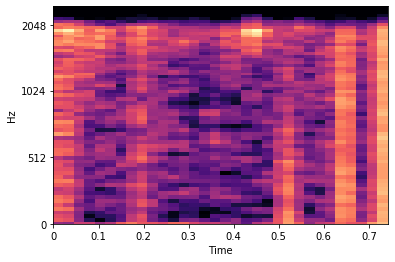

In [2]:
import glob
    
file_list = glob.glob(f"/data/NRS10/2015-2016/*.wav")
file_list.sort()

y, sr = librosa.load(
    "./output/damselfish/30.wav",
    offset=0,
)

sg = librosa.feature.melspectrogram(y, sr=sr,  n_fft=2048, hop_length=512, power=2.0, n_mels=64, fmin=0.0, fmax=2500)
sg0 = librosa.stft(y)
sg_mag, sg_phase = librosa.magphase(sg0)

#sg1 = librosa.feature.melspectrogram(S=sg_mag, sr=5000)
#librosa.display.specshow(sg1)

db_spec = librosa.amplitude_to_db(sg, ref=np.min, top_db=60.0)
librosa.display.specshow(db_spec, y_axis='mel', fmax=2500, x_axis='time')

#Image.show(torch.from_numpy(sg2).unsqueeze(0), figsize=(15, 5), cmap=None)

In [3]:
path = Path("output/")

#sg = librosa.feature.melspectrogram(y, sr=sr,  n_fft=1024, hop_length=256, power=2.0, n_mels=64, fmin=0.0, fmax=2500)
#db_spec = librosa.amplitude_to_db(sg, ref=1.0, amin=1e-04, top_db=40.0)
#librosa.display.specshow(db_spec, y_axis='mel', fmax=2500, hop_length=256, x_axis='time')

sg_cfg = SpectrogramConfig(n_fft=2560, hop_length=256, n_mels=192, top_db=60, f_max=2500)

config = AudioConfig(
    use_spectro=True,
    sg_cfg=sg_cfg,
    duration=1000
)

#label_pattern = r'_([mf]\d+)_'
al = AudioList.from_folder(path, config=config).split_by_rand_pct(.2, seed=4).label_from_folder()
#al = AudioList.from_folder(path, config=config).split_by_rand_pct(.2, seed=4).label_const("damselfish")

In [4]:
#tfms = get_spectro_transforms(mask_time=False, mask_freq=True, roll=False, num_rows=12)
tfms = None
db = al.transform(tfms).databunch(bs=64)
db.show_batch(rows=10)

------------------------------------------------------------
File: output/damselfish/60.wav
Total Length: 0.67 seconds
Number of Channels: 1
Label: damselfish
Channel 0.0 (192x19):
------------------------------------------------------------
File: output/damselfish/125.wav
Total Length: 0.78 seconds
Number of Channels: 1
Label: damselfish
Channel 0.0 (192x19):
------------------------------------------------------------
File: output/damselfish/18.wav
Total Length: 0.8 seconds
Number of Channels: 1
Label: damselfish
Channel 0.0 (192x19):
------------------------------------------------------------
File: output/damselfish/199.wav
Total Length: 0.63 seconds
Number of Channels: 1
Label: damselfish
Channel 0.0 (192x19):
------------------------------------------------------------
File: output/damselfish/162.wav
Total Length: 0.71 seconds
Number of Channels: 1
Label: damselfish
Channel 0.0 (192x19):
------------------------------------------------------------
File: output/damselfish/124.wav


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


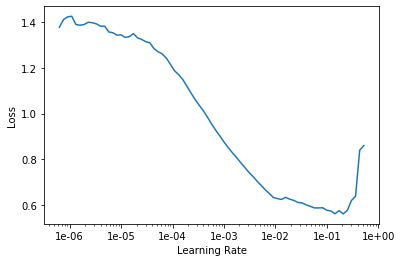

In [8]:
learn = audio_learner(db)

#learn = cnn_learner(db, models.densenet161, metrics=accuracy, callback_fns=ShowGraph, pretrained=True).mixup()

#learn = cnn_learner(db, models.densenet161, metrics=accuracy)

learn.lr_find()
learn.recorder.plot()

In [9]:
learn.fit_one_cycle(17, slice(1e-5, 1e-3))

epoch,train_loss,valid_loss,accuracy,time
0,1.264442,1.378466,0.500000,00:00
1,1.248211,1.109065,0.512195,00:00
2,1.087336,0.561880,0.707317,00:00
3,0.932356,0.452228,0.780488,00:00
4,0.766190,0.529570,0.829268,00:00
5,0.650988,0.508353,0.853659,00:00
6,0.548502,0.369698,0.890244,00:00
7,0.477265,0.259378,0.914634,00:00
8,0.413531,0.302121,0.914634,00:00
9,0.362902,0.468374,0.902439,00:00


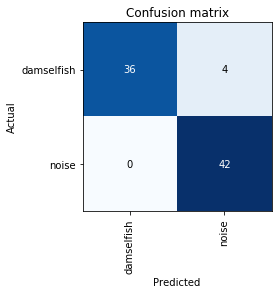

In [16]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

In [16]:
#learn.save("/workspaces/sonumator/stage1")
learn.unfreeze()

learn.fit_one_cycle(3, max_lr=slice(1e-4, 1e-2))

epoch,train_loss,valid_loss,accuracy,time
0,0.012384,0.955759,0.902439,00:00
1,0.239974,11.087714,0.792683,00:00
2,0.260568,0.351374,0.975610,00:00


In [17]:
learn.save('/workspaces/sonumator/stage1')

In [18]:
learn = audio_learner(db)
learn.load("/workspaces/sonumator/stage1")

Learner(data=AudioDataBunch;

Train: AudioLabelList (332 items)
x: AudioList
AudioItem 0.67 seconds (1 channels, 3349 samples @ 5000hz),AudioItem 0.78 seconds (1 channels, 3899 samples @ 5000hz),AudioItem 0.8 seconds (1 channels, 4014 samples @ 5000hz),AudioItem 0.63 seconds (1 channels, 3149 samples @ 5000hz),AudioItem 0.71 seconds (1 channels, 3550 samples @ 5000hz)
y: CategoryList
damselfish,damselfish,damselfish,damselfish,damselfish
Path: output;

Valid: AudioLabelList (82 items)
x: AudioList
AudioItem 1.5 seconds (1 channels, 7500 samples @ 5000hz),AudioItem 1.5 seconds (1 channels, 7500 samples @ 5000hz),AudioItem 0.78 seconds (1 channels, 3905 samples @ 5000hz),AudioItem 0.68 seconds (1 channels, 3386 samples @ 5000hz),AudioItem 1.5 seconds (1 channels, 7500 samples @ 5000hz)
y: CategoryList
noise,noise,damselfish,damselfish,noise
Path: output;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

(Category damselfish, tensor(0), tensor([1.0000e+00, 2.7849e-19]))

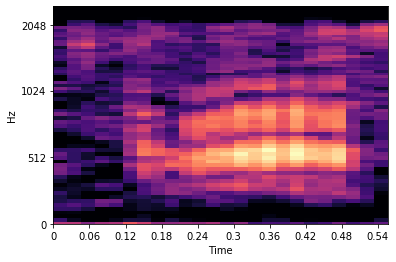

In [14]:
newsample_path = "damnew2.wav"
y, sr = librosa.load(
    newsample_path,
    offset=0,
)

sg = librosa.feature.melspectrogram(y, sr=sr,  n_fft=2048, hop_length=512, power=2.0, n_mels=64, fmin=0.0, fmax=2500)
sg0 = librosa.stft(y)
sg_mag, sg_phase = librosa.magphase(sg0)
db_spec = librosa.amplitude_to_db(sg, ref=np.min, top_db=60.0)
librosa.display.specshow(db_spec, y_axis='mel', fmax=2500, x_axis='time')

item = AudioItem(path=newsample_path)

audio_predict(learn, item)

In [21]:
learn.save('/workspaces/sonumator/stage2')

In [5]:
learn = audio_learner(db)
learn.load("/workspaces/sonumator/stage2")

Learner(data=AudioDataBunch;

Train: AudioLabelList (332 items)
x: AudioList
AudioItem 0.67 seconds (1 channels, 3349 samples @ 5000hz),AudioItem 0.78 seconds (1 channels, 3899 samples @ 5000hz),AudioItem 0.8 seconds (1 channels, 4014 samples @ 5000hz),AudioItem 0.63 seconds (1 channels, 3149 samples @ 5000hz),AudioItem 0.71 seconds (1 channels, 3550 samples @ 5000hz)
y: CategoryList
damselfish,damselfish,damselfish,damselfish,damselfish
Path: output;

Valid: AudioLabelList (82 items)
x: AudioList
AudioItem 1.5 seconds (1 channels, 7500 samples @ 5000hz),AudioItem 1.5 seconds (1 channels, 7500 samples @ 5000hz),AudioItem 0.78 seconds (1 channels, 3905 samples @ 5000hz),AudioItem 0.68 seconds (1 channels, 3386 samples @ 5000hz),AudioItem 1.5 seconds (1 channels, 7500 samples @ 5000hz)
y: CategoryList
noise,noise,damselfish,damselfish,noise
Path: output;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

In [50]:
import torchaudio
import pandas as pd

def search_file_for_samples(filepath, model, offset=2):
    df = pd.DataFrame(columns=["start", "end"])

    si, ei = torchaudio.info(filepath)
    length = si.length / si.rate

    for i in range(0, int(length), offset):
        end = i + offset
        item = AudioItem(sr=5000, path=filepath, start=i, end=end)
        category, _, _ = audio_predict(learn, item)
        if str(category) == "damselfish":
            df = df.append([{"start": i, "end": end}])
    
    return df

df = search_file_for_samples("recordings/20150623-044023.wav", learn)
df.index = range(len(df.index))
df.head(20)

start    42
end      44
Name: 15, dtype: object
(Category damselfish, tensor(0), tensor([0.9989, 0.0011]))
start    46
end      48
Name: 16, dtype: object
(Category noise, tensor(1), tensor([8.8863e-09, 1.0000e+00]))
start    50
end      52
Name: 17, dtype: object
(Category noise, tensor(1), tensor([0.4205, 0.5795]))
start    52
end      54
Name: 18, dtype: object
(Category noise, tensor(1), tensor([0.0119, 0.9881]))
start    54
end      56
Name: 19, dtype: object
(Category damselfish, tensor(0), tensor([0.9915, 0.0085]))


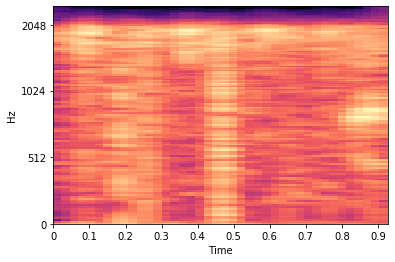

In [77]:
for i in range(15, 20):
    row = df.iloc[i]
    start = row[0]
    end = row[1]

    item = AudioItem(sr=5000, path="recordings/20150623-044023.wav", start=start, end=end)
    print(row)
    print(audio_predict(learn, item))

    y, sr = librosa.load(
        "recordings/20150623-044023.wav",
        offset=start,
        duration=2
    )

    sg = librosa.feature.melspectrogram(y, sr=sr,  n_fft=2048, hop_length=256, power=1.0, n_mels=128, fmin=0.0, fmax=2500)
    sg0 = librosa.stft(y)
    sg_mag, sg_phase = librosa.magphase(sg0)

    #sg1 = librosa.feature.melspectrogram(S=sg_mag, sr=5000)
    #librosa.display.specshow(sg1)

    db_spec = librosa.amplitude_to_db(sg, ref=np.min, top_db=60.0)
    librosa.display.specshow(db_spec, y_axis='mel', fmax=2500, x_axis='time')


In [75]:
item = AudioItem(sr=5000, path="recordings/20150623-044023.wav", start=54, end=56)
category, _, _ = audio_predict(learn, item)
category

Category damselfish

In [73]:
len(df)

5168